In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.stats as stats
from tqdm import tqdm
from scipy.sparse.linalg import eigsh

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Set parameters

In [2]:
n = 2000 # sample size
c = 0.2 # p/n
alpha = 0.1 # L/n
beta = alpha/c

p = int(c*n) # dimension
L = int(alpha*n) # band size
setting = "$n = {} \quad p = {} \quad L = {}$".format(n, p, L)

mu_norms = np.linspace(1, 3, 20)
max_nvecs = 9

k = 2 # number of classes
pi = np.array([0.5, 0.5]) # proportion of each class
# centroid of each class
mu = stats.norm.rvs(size=(p, 1))
mu /= np.linalg.norm(mu)
M0 = np.concatenate([+mu, -mu], axis=1)

J = utils.getJ(n, pi)

# Computations

In [3]:
est = np.zeros((len(mu_norms), max_nvecs, n))
Q = np.zeros(len(mu_norms))

B = utils.gen_mask(n, L, kind='toeplitz')
tau, _ = linalg.eigh(B)
for i, mu_norm in enumerate(tqdm(mu_norms)):
    M = mu_norm*M0
    P = M@J.T
    Z = stats.norm.rvs(size=(p, n))
    X = P+Z
    K = (X.T.conj()@X)*B/p
    
    first_spike = eigsh(K, k=1, which='LA')[0][0]
    mu_norm_est = utils.est_mu(n, p, L, first_spike, tau)
    _, (spikes_idx_est, _, _, _) = utils.get_spikes(n, p, L, mu_norm_est, tau)
    
    i_top = spikes_idx_est[spikes_idx_est >= n//2].min(initial=n)
    i_bottom = spikes_idx_est[spikes_idx_est < n//2].max(initial=-1)+1
    eigvecs_t = np.empty((n, n))
    eigvecs_t[:] = np.nan
    if n-i_top > 0:
        eigvecs_t[i_top:] = eigsh(K, k=n-i_top, which='LA')[1].T
    if i_bottom > 0:
        eigvecs_t[:i_bottom] = eigsh(K, k=i_bottom, which='SA')[1].T
    
    points = eigvecs_t[spikes_idx_est[:max_nvecs]]
    for j in range(max_nvecs):
        nvecs = j+1
        w = np.mean(np.sign(points[0])*points[:nvecs], axis=1)
        est[i, j] = (w.T)@points[:nvecs]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.13s/it]


In [4]:
mu2, tau_k, tau_l = np.meshgrid(mu_norms**2, tau, tau)
zeta_ = np.mean((1-p*(tau_l/((mu2+1)*tau_k-tau_l))**2)*(mu2/(mu2+1)), axis=2)
zeta_ = np.maximum(0, zeta_)
Q = stats.norm.sf(np.sqrt(zeta_/(1-zeta_)))

In [5]:
cerr = np.mean(np.tile(J[:, 0]-J[:, 1], len(mu_norms)*max_nvecs).reshape(est.shape) == np.sign(est), axis=-1)
cerr = np.minimum(cerr, 1-cerr)

# Visualisation

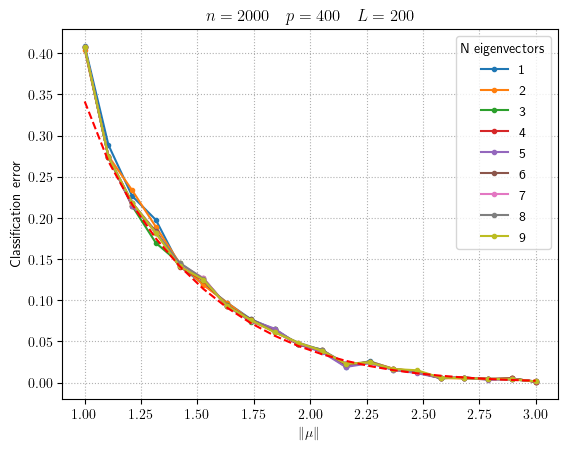

In [6]:
plt.plot(mu_norms, cerr, marker='.', ls='-')
plt.plot(mu_norms, Q[-1, :], ls='--', color='r')
plt.grid(ls=':')
plt.xlabel("$\\| \\mu \\|$")
plt.ylabel("Classification error")
plt.title(setting)
plt.legend(range(1, max_nvecs+1), title="N eigenvectors")
plt.show()

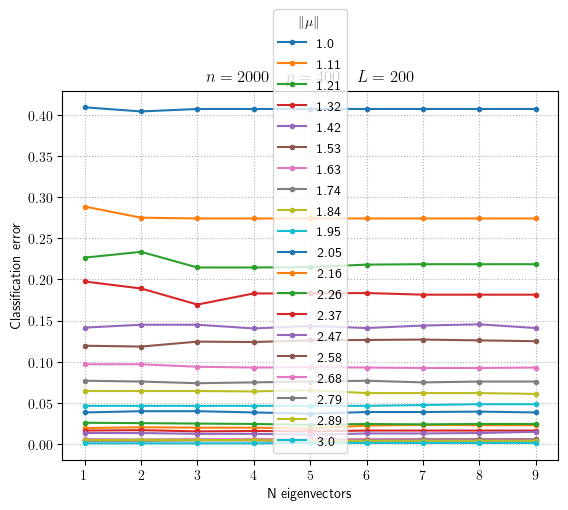

In [7]:
plt.plot(range(1, max_nvecs+1), cerr.T, marker='.', ls='-')
plt.grid(ls=':')
plt.xlabel("N eigenvectors")
plt.ylabel("Classification error")
plt.title(setting)
plt.legend(np.round(mu_norms, 2), title="$\\| \\mu \\|$")
plt.show()